<a href="https://colab.research.google.com/github/jvafable/macroscopic-traffic-model/blob/main/Macroscopic_Traffic_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
EPS = 10**-7
class Cell:
    global EPS
    global delta_t
    def __init__(self):
        self.density = 0.0
        self.velocity = 0.0
        self.flux = 0.0

        self.flux_limiting_coeff = 1.0
        self.delta_x = 50.0

        self.theta_1 = -1.8     # slope, segm. 1
        self.theta_2 = 13.8     # velocity_max
        self.theta_3 = 0.0598   # transition segm. 1-2
        self.theta_4 = 0.095    # transition segm. 2-3
        self.theta_5 = 2.3      # speed at transition 2-3
        self.theta_6 = 0.13     # density_max
        self.alpha = 0.295

        self.velocity = self.theta_2

    def __repr__(self):
        return f"density : {self.density:.10f}, velocity : {self.velocity:.5f}, flux : {self.flux:.5f}, coeff : {self.flux_limiting_coeff:.5f}, delta_x = {self.delta_x}"

    def compute_velocity(self):
        '''
          compute_velocity
            Computes for the velocity based on its corresponding density in the Fundamental Diagram (FD).

            Returns the velocity computed.
        '''
        assert -EPS <= self.density <= self.theta_6 + EPS, f"Density is {self.density}"

        if -EPS <= self.density < self.theta_3 + EPS:
            return  self.theta_1 * self.density + self.theta_2  # free flow segment

        if self.theta_3 - EPS <= self.density < self.theta_4 + EPS:         # between segment
            v1 = self.theta_1 * self.theta_3 + self.theta_2
            v2 = self.theta_5
            rise = v2 - v1
            run = self.theta_4 - self.theta_3
            slope = rise / run 
            return slope * (self.density - self.theta_3) + v1

        if self.theta_4 -EPS <= self.density <= self.theta_6 + EPS:        # congested segment
            rise = -self.theta_5
            run = self.theta_6 - self.theta_4
            slope = rise / run
            return slope * (self.density - self.theta_4) + self.theta_5

class Road:
    global delta_t
    def __init__(self, num_cells = 0):
        self.cells = [Cell() for i in range(num_cells)]
        self.ncells = num_cells
        self.inflow_cell = Cell()
        self.outflow_cell = Cell()

    def __getitem__(self, key):
        if key == 0:
            return self.inflow_cell

        if key == self.ncells + 1:
            return self.outflow_cell

        return self.cells[key-1]

    def __setitem__(self, key, value):
        if key == 0:
            self.inflow_cell = value

        elif key == self.ncells + 1:
            self.outflow_cell = value

        elif 1 <= key <= self.ncells:
            self.cells[key-1] = value

    def __repr__(self):
        stuff = [f"Cell #:{i}, {str(self[i])}" for i in range(self.ncells+2)]
        return "\n".join(stuff)


    def set_num_cells(self, num):
        self.cells = [Cell() for i in range(num)]
        self.ncells = num

    def time_iterate(self):
        '''
          time_iterate
            Computes for density, velocity, and flux of each cell in a road segment in a single time increment
        '''


        for i in range(self.ncells, 0, -1):
            outgoing_flux = self[i].flux
            remaining_flux = (self[i].theta_6 - self[i].density) * (self[i].delta_x / delta_t) + outgoing_flux
            incoming_flux = min(self[i-1].flux, remaining_flux)
            
            self[i].density = self[i].density + (incoming_flux - outgoing_flux) * (delta_t / self[i-1].delta_x)  # Equation 6

            if self[i].density < 0:
              self[i].density = 0
              # This feels like we are randomly injecting car density out of nowhere
  
            self[i].velocity = (1 - self[i].alpha) * self[i].compute_velocity() + (self[i].alpha) * self[i+1].velocity   # Equation 4
            self[i].flux = self[i].density * self[i].velocity   # Equation 2

            if i > 1:
              self[i-1].flux = incoming_flux

    def simulate(self, T):
        '''
          simulate(self, duration / number of time increments)
            Initializes values of ghost cells, computes for the flux limiting coefficients of each cell, and computes for the density, velocity, and flux of each cell in a road segment. This is repeated duration T times. 
            
            Returns 3 dictionaries containing the fluxes, densities, and the cells at all time increments within the computation.

        '''
        flux_record = {f"Cell #{i}" : [] for i in range(self.ncells+2)}
        density_record = {f"Cell #{i}" : [] for i in range(self.ncells+2)}

        
        # Values of inflow ghost cell
        self.inflow_cell.density = 0.125    
        self.inflow_cell.velocity = (1 - self.inflow_cell.alpha) * self.inflow_cell.compute_velocity() + (self[1].alpha) * self[1].compute_velocity()
        self.inflow_cell.flux = self.inflow_cell.density * self.inflow_cell.velocity


        for t in range(T):
           

            # Values of outflow ghost cell
            self.outflow_cell.density = 0.
            self.outflow_cell.velocity = self.outflow_cell.compute_velocity()
            self.outflow_cell.flux = 0

            # Compute for flux limiting coefficients

            # for i in range(self.ncells, 0, -1):
            #     if self[i-1].flux == 0:
            #         self[i].flux_limiting_coeff = 1
            #     else:
            #         self[i].flux_limiting_coeff = ((self[i].theta_6 - self[i].density) * (self[i].delta_x / delta_t) + self[i+1].flux_limiting_coeff * self[i].flux) / (self[i-1].flux)  # Equation 13

            #         self[i].flux_limiting_coeff = min(self[i].flux_limiting_coeff, 1.0)
            #         self[i].flux_limiting_coeff = max(self[i].flux_limiting_coeff, 0.0)

            self.time_iterate()   # Compute for density, velocity, flux

            # Compile and append records of data
            for r in range(self.ncells+2):
              flux_record[f"Cell #{r}"].append(self[r].flux)
              density_record[f"Cell #{r}"].append(self[r].density)

        return {"flux" : flux_record, "density" : density_record, "cells" : self.cells}

class Network:
    global delta_t
    def __init__(self, turnrate, order, stoplight):
      self.turnrate = turnrate
      self.roads = [Road(50) for i in self.turnrate]
      self.N = len(self.roads)
      self.order = order
      self.stoplight = stoplight
      # self.

    def simulate(self, T):
      global delta_t
      flux_record = [{f"Cell #{i}" : [] for i in range(road.ncells+2)} for road in self.roads]
      density_record = [{f"Cell #{i}" : [] for i in range(road.ncells+2)} for road in self.roads]
      for t in range(T):
        f = [1.0 for i in range(self.N)]
        flux_accumulator = [0 for i in range(self.N)]

        # outflow boundary cell first
        for r in range(self.N):
          cur_road = self.roads[r]
          ncells = cur_road.ncells
          # Values of inflow ghost cell
          cur_road.inflow_cell.density = 0.125    
          cur_road.inflow_cell.velocity = (1 - cur_road.inflow_cell.alpha) * cur_road.inflow_cell.compute_velocity() + (cur_road[1].alpha) * cur_road[1].compute_velocity()
          cur_road.inflow_cell.flux = cur_road.inflow_cell.density * cur_road.inflow_cell.velocity

          # Values of outflow ghost cell
          cur_road.outflow_cell.density = 0.
          cur_road.outflow_cell.velocity = cur_road.outflow_cell.compute_velocity()
          cur_road.outflow_cell.flux = 0

          if not self.turnrate[r, :].any():
            remaining_flux = (cur_road[ncells+1].theta_6 - cur_road[ncells+1].density) * (cur_road[ncells+1].delta_x / delta_t)
            incoming_flux = min(cur_road[ncells].flux, remaining_flux)
            flux_accumulator[r] = incoming_flux

        for road_i in self.order:
          cur_road = self.roads[road_i]
          ncells = cur_road.ncells
          cur_road[ncells].flux = flux_accumulator[road_i]

          for i in range(cur_road.ncells, 1, -1):

            # Stoplight
            if i == cur_road.ncells:
              if self.stoplight[road_i]:
                if self.stoplight[road_i][0] <= t%self.stoplight[road_i][2] < self.stoplight[road_i][1]:
                    outgoing_flux = cur_road[i].flux
                else:
                    outgoing_flux = 0.0
              else:
                  outgoing_flux = cur_road[i].flux
            else:
              outgoing_flux = cur_road[i].flux

            # outgoing_flux = min(cur_road[i].density * (cur_road[i].delta_x / delta_t), outgoing_flux)
            # if outgoing_flux * (delta_t / cur_road[i].delta_x) > cur_road[i].density:
            #   k = cur_road[i].density / (outgoing_flux * (delta_t / cur_road[i].delta_x))
            #   outgoing_flux = k * outgoing_flux

            remaining_flux = (cur_road[i].theta_6 - cur_road[i].density) * (cur_road[i].delta_x / delta_t) + outgoing_flux
            incoming_flux = min(cur_road[i-1].flux, remaining_flux)
            
            cur_road[i].density = cur_road[i].density + (incoming_flux - outgoing_flux) * (delta_t / cur_road[i].delta_x)  # Equation 6

            if cur_road[i].density < 0:
              cur_road[i].density = 0
              # This feels like we are randomly injecting car density out of nowhere
  
            cur_road[i].velocity = (1 - cur_road[i].alpha) * cur_road[i].compute_velocity() + (cur_road[i].alpha) * cur_road[i+1].velocity   # Equation 4
            cur_road[i].flux = cur_road[i].density * cur_road[i].velocity   # Equation 2
            cur_road[i-1].flux = incoming_flux
          
          # Merge Model
          if self.turnrate[:, road_i].any():
            unrestricted_flow = 0
            for r in range(self.N):
              incoming_road = self.roads[r]
              incoming_ncells = incoming_road.ncells
              unrestricted_flow += self.turnrate[r, road_i] * incoming_road[incoming_ncells].flux

            outgoing_flux = cur_road[1].flux
            # if outgoing_flux * (delta_t / cur_road[1].delta_x) > cur_road[1].density:
            #   k = cur_road[1].density / (outgoing_flux * (delta_t / cur_road[1].delta_x))
            #   outgoing_flux = k * outgoing_flux
            remaining_flux = (cur_road[1].theta_6 - cur_road[1].density) * (cur_road[1].delta_x / delta_t) + outgoing_flux

            ratio = 1.0
            if unrestricted_flow == 0:
              ratio = 1.0
            else:
              ratio = min(1.0, remaining_flux / unrestricted_flow)
            f[road_i] = ratio
            incoming_flux = unrestricted_flow * f[road_i]

            # Just for visualization purposes
            cur_road[0].density = incoming_flux * (delta_t / cur_road[1].delta_x)
            
            cur_road[1].density = cur_road[1].density + (incoming_flux - outgoing_flux) * (delta_t / cur_road[1].delta_x)  # Equation 6
            if cur_road[1].density < 0:
              cur_road[1].density = 0
              # This feels like we are randomly injecting car density out of nowhere


            cur_road[1].velocity = (1 - cur_road[1].alpha) * cur_road[1].compute_velocity() + (cur_road[1].alpha) * cur_road[2].velocity   # Equation 4
            cur_road[1].flux = cur_road[1].density * cur_road[1].velocity   # Equation 2
            # cur_road[i-1].flux = incoming_flux

            for r in range(self.N):
              flux_accumulator[r] += f[road_i] * self.turnrate[r][road_i] * self.roads[r][self.roads[r].ncells].flux

          else:
            outgoing_flux = cur_road[1].flux
            # if outgoing_flux * (delta_t / cur_road[1].delta_x) > cur_road[1].density:
            #   k = cur_road[1].density / (outgoing_flux * (delta_t / cur_road[1].delta_x))
            #   outgoing_flux = k * outgoing_flux
            remaining_flux = (cur_road[1].theta_6 - cur_road[1].density) * (cur_road[1].delta_x / delta_t) + outgoing_flux
            incoming_flux = min(cur_road[0].flux, remaining_flux)
            
            cur_road[1].density = cur_road[1].density + (incoming_flux - outgoing_flux) * (delta_t / cur_road[1].delta_x)  # Equation 6

            if cur_road[1].density < 0:
              cur_road[1].density = 0
              # This feels like we are randomly injecting car density out of nowhere
  
            cur_road[1].velocity = (1 - cur_road[1].alpha) * cur_road[1].compute_velocity() + (cur_road[1].alpha) * cur_road[2].velocity   # Equation 4
            cur_road[1].flux = cur_road[1].density * cur_road[1].velocity   # Equation 2
            # cur_road[i-1].flux = incoming_flux

      # Compile and append records of data
        for road_i in range(self.N):
          cur_road = self.roads[road_i]
          for r in range(self.roads[road_i].ncells+2):

            flux_record[road_i][f"Cell #{r}"].append(cur_road[r].flux)
            density_record[road_i][f"Cell #{r}"].append(cur_road[r].density)

      return {"flux" : flux_record, "density" : density_record}
  


#a[k][l] = incoming k, to outgoing l



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

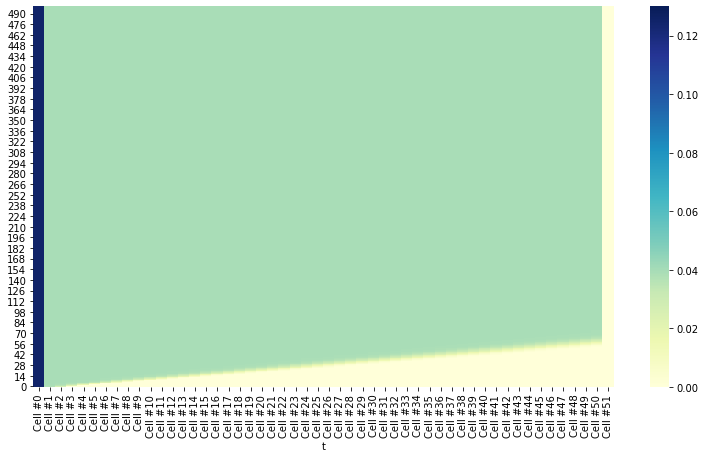

In [3]:
%matplotlib inline
delta_t = 3
random.seed(7777777)
test = Road(50)
records = test.simulate(500)
density_records = pd.DataFrame(records['density'], )
fig, ax = plt.subplots(figsize=(13, 7)) 
sns.heatmap(density_records, cmap="YlGnBu", ax = ax, vmin=0.0, vmax=0.13)
# sns.heatmap(density_records, cmap="coolwarm")
# ax.set_size((13, 7))
ax.invert_yaxis()
ax.set_xlabel('t')
ax
plt.show()

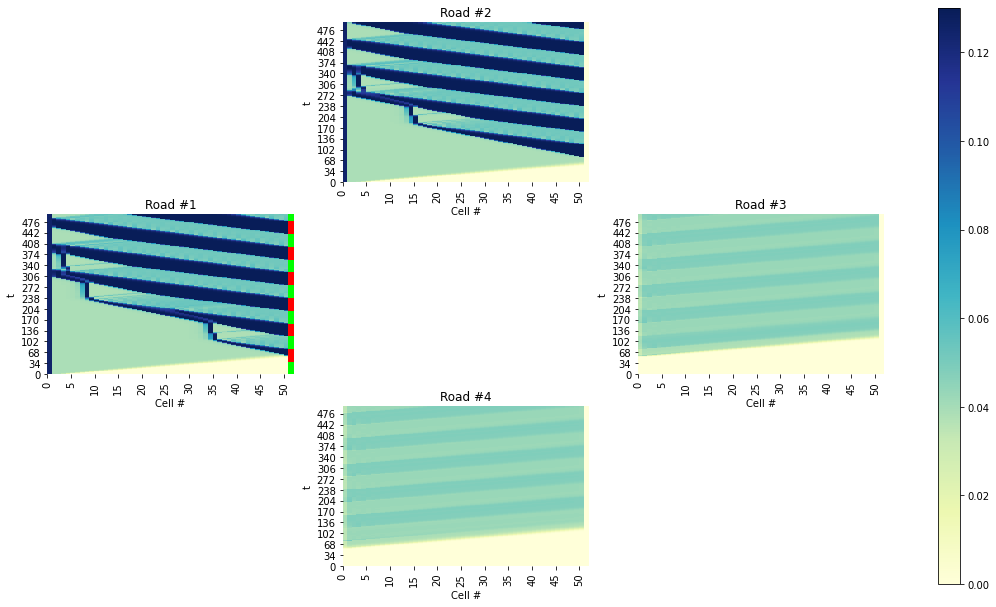

In [46]:
%matplotlib inline
from matplotlib.collections import QuadMesh
delta_t = 3
turnrate = np.array([
                     [0.0, 0.0, 0.7, 0.3], 
                     [0.0, 0.0, 0.3, 0.7], 
                     [0.0, 0.0, 0.0, 0.0], 
                     [0.0, 0.0, 0.0, 0.0]])
order = [2, 3, 0, 1]
stoplight = [(0, 40, 80), (40, 80, 80), 0, 0]
network = Network(turnrate, order, stoplight)
records = network.simulate(500)

# Road 1
density_records = [pd.DataFrame(records['density'][i]) for i in range(4)]
fig, axes = plt.subplots(3, 3, figsize=(15, 10)) 

mapping = {
    (0, 0) : (1, 0), 
    (0, 1) : (0, 1),
    (1, 0) : (1, 2),
    (1, 1) : (2, 1),
}

for i, ax in enumerate(axes.flatten()):
  ax.axis('off')




sns.heatmap(density_records[0], cmap="YlGnBu", ax = axes[mapping[0, 0]], cbar=False, vmin=0.0, vmax=0.13)
sns.heatmap(density_records[1], cmap="YlGnBu", ax = axes[mapping[0, 1]], cbar=False, vmin=0.0, vmax=0.13)
sns.heatmap(density_records[2], cmap="YlGnBu", ax = axes[mapping[1, 0]], cbar=False, vmin=0.0, vmax=0.13)
sns.heatmap(density_records[3], cmap="YlGnBu", ax = axes[mapping[1, 1]], cbar=False, vmin=0.0, vmax=0.13)
# sns.heatmap(density_records, cmap="coolwarm")
# ax.set_size((13, 7))


for i in range(2):
  for j in range(2):
    id = i*2 + j + 1
    axes[mapping[i,j]].axis('on')
    axes[mapping[i,j]].set_title(f'Road #{id}')
    axes[mapping[i,j]].invert_yaxis()
    axes[mapping[i,j]].set_xticks(list(range(0, 52, 5)))
    axes[mapping[i,j]].set_xticklabels(list(range(0, 52, 5)))
    axes[mapping[i,j]].set_ylabel('t')
    axes[mapping[i,j]].set_xlabel('Cell #')

quadmesh = axes[mapping[0,0]].findobj(QuadMesh)[0]
facecolors = quadmesh.get_facecolors()
green_zone = np.array([True  if 0 <= i%80 < 40 else False for i in np.arange(500)])
red_zone = ~green_zone
make_green = np.arange(51, len(facecolors), 52)[green_zone]
make_red = np.arange(51, len(facecolors), 52)[red_zone]
facecolors[make_green] = np.array([0,1,0,1])
facecolors[make_red] = np.array([1,0,0,1])
quadmesh.set_facecolors(facecolors)


quadmesh = axes[mapping[0,1]].findobj(QuadMesh)[0]
facecolors = quadmesh.get_facecolors()
green_zone = np.array([True  if 40 <= i%80 < 80 else False for i in np.arange(500)])
red_zone = ~green_zone
make_green = np.arange(51, len(facecolors), 52)[green_zone]
make_red = np.arange(51, len(facecolors), 52)[red_zone]
facecolors[make_green] = np.array([0,1,0,1])
facecolors[make_red] = np.array([1,0,0,1])
quadmesh.set_facecolors(facecolors)
# fig.tight_layout()


cbar_ax = fig.add_axes([.95, .1, .02, .8])
fig.colorbar(axes[0, 1].collections[0], cax=cbar_ax)
# fig.tight_layout()
# fig.colorbar(axes[0, 1].collections[0], cax=cbar_ax, orientation="horizontal")

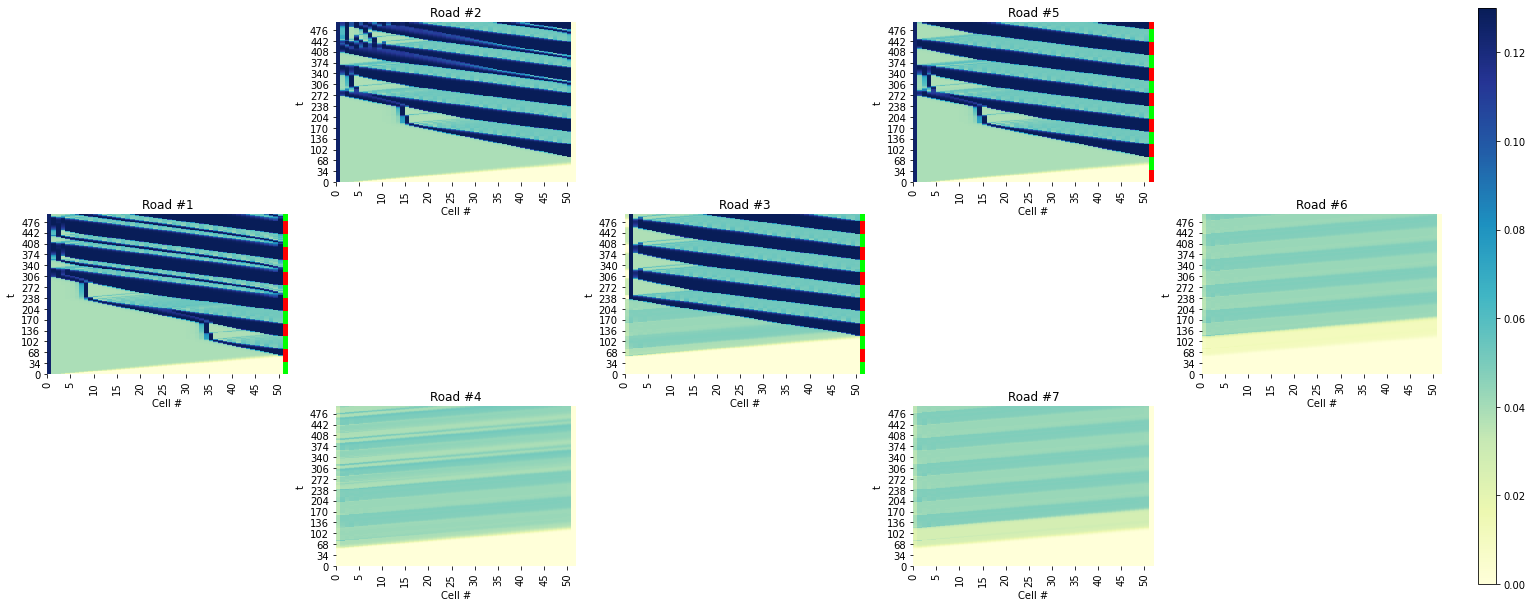

In [55]:
%matplotlib inline
from matplotlib.collections import QuadMesh
from math import floor, ceil
T = 500
delta_t = 3
turnrate = np.array([
                     [0.0, 0.0, 0.7, 0.3, 0.0, 0.0, 0.0], 
                     [0.0, 0.0, 0.3, 0.7, 0.0, 0.0, 0.0], 
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3], 
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.7],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
order = [5, 6, 4, 2, 3, 0, 1]
stoplight = [(0, 40, 80), (40, 80, 80), (0, 40, 80), 0, (40, 80, 80), 0, 0]
network = Network(turnrate, order, stoplight)
records = network.simulate(T)

num_rows = ceil(len(order) / 2)
num_cols = 2
density_records = [pd.DataFrame(records['density'][i]) for i in range(len(order))]
fig, axes = plt.subplots(3, 5, figsize=(25, 10)) 

mapping = {
    (0, 0) : (1, 0), 
    (0, 1) : (0, 1),
    (1, 0) : (1, 2),
    (1, 1) : (2, 1),
    (2, 0) : (0, 3),
    (2, 1) : (1, 4),
    (3, 0) : (2, 3),
}

color_map = plt.cm.get_cmap('YlGnBu')
# color_map = color_map.reversed()
for r in range(len(order)):
  i = r // 2
  j = r % 2
  i, j = mapping[i, j]
  # sns.heatmap(density_records[r], cmap="YlGnBu", ax = axes[i, j], vmin=0.0, vmax=0.13)
  sns.heatmap(density_records[r], cmap=color_map, ax = axes[i, j], cbar=False, vmin=0.0, vmax=0.13)

for i, ax in enumerate(axes.flat):
  ax.axis('off')

for i in range(num_rows):
  for j in range(num_cols):
    if (i, j) not in mapping:
      continue
    axes[mapping[i,j]].invert_yaxis()
    axes[mapping[i,j]].set_xticks(list(range(0, 52, 5)))
    axes[mapping[i,j]].set_xticklabels(list(range(0, 52, 5)))
    axes[mapping[i,j]].set_ylabel('t')
    axes[mapping[i,j]].set_xlabel('Cell #')
    axes[mapping[i,j]].set_title(f'Road #{2*i + j + 1}')
    axes[mapping[i,j]].axis('on')
    if 2*i + j >= len(order):
      # axes[mapping[i,j]].clear()
      # axes[mapping[i,j]].axis('off')
      continue

    if not stoplight[2*i + j]:
      continue

    id = 2*i + j
    quadmesh = axes[mapping[i,j]].findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()
    green_zone = np.array([True  if stoplight[id][0] <= i%stoplight[id][2] < stoplight[id][1] else False for i in np.arange(T)])
    red_zone = ~green_zone
    make_green = np.arange(51, len(facecolors), 52)[green_zone]
    make_red = np.arange(51, len(facecolors), 52)[red_zone]
    facecolors[make_green] = np.array([0,1,0,1])
    facecolors[make_red] = np.array([1,0,0,1])
    quadmesh.set_facecolors(facecolors)

cbar_ax = fig.add_axes([.92, .1, .01, .8])
fig.colorbar(axes[0, 1].collections[0], cax=cbar_ax)
# fig.tight_layout()
plt.show()

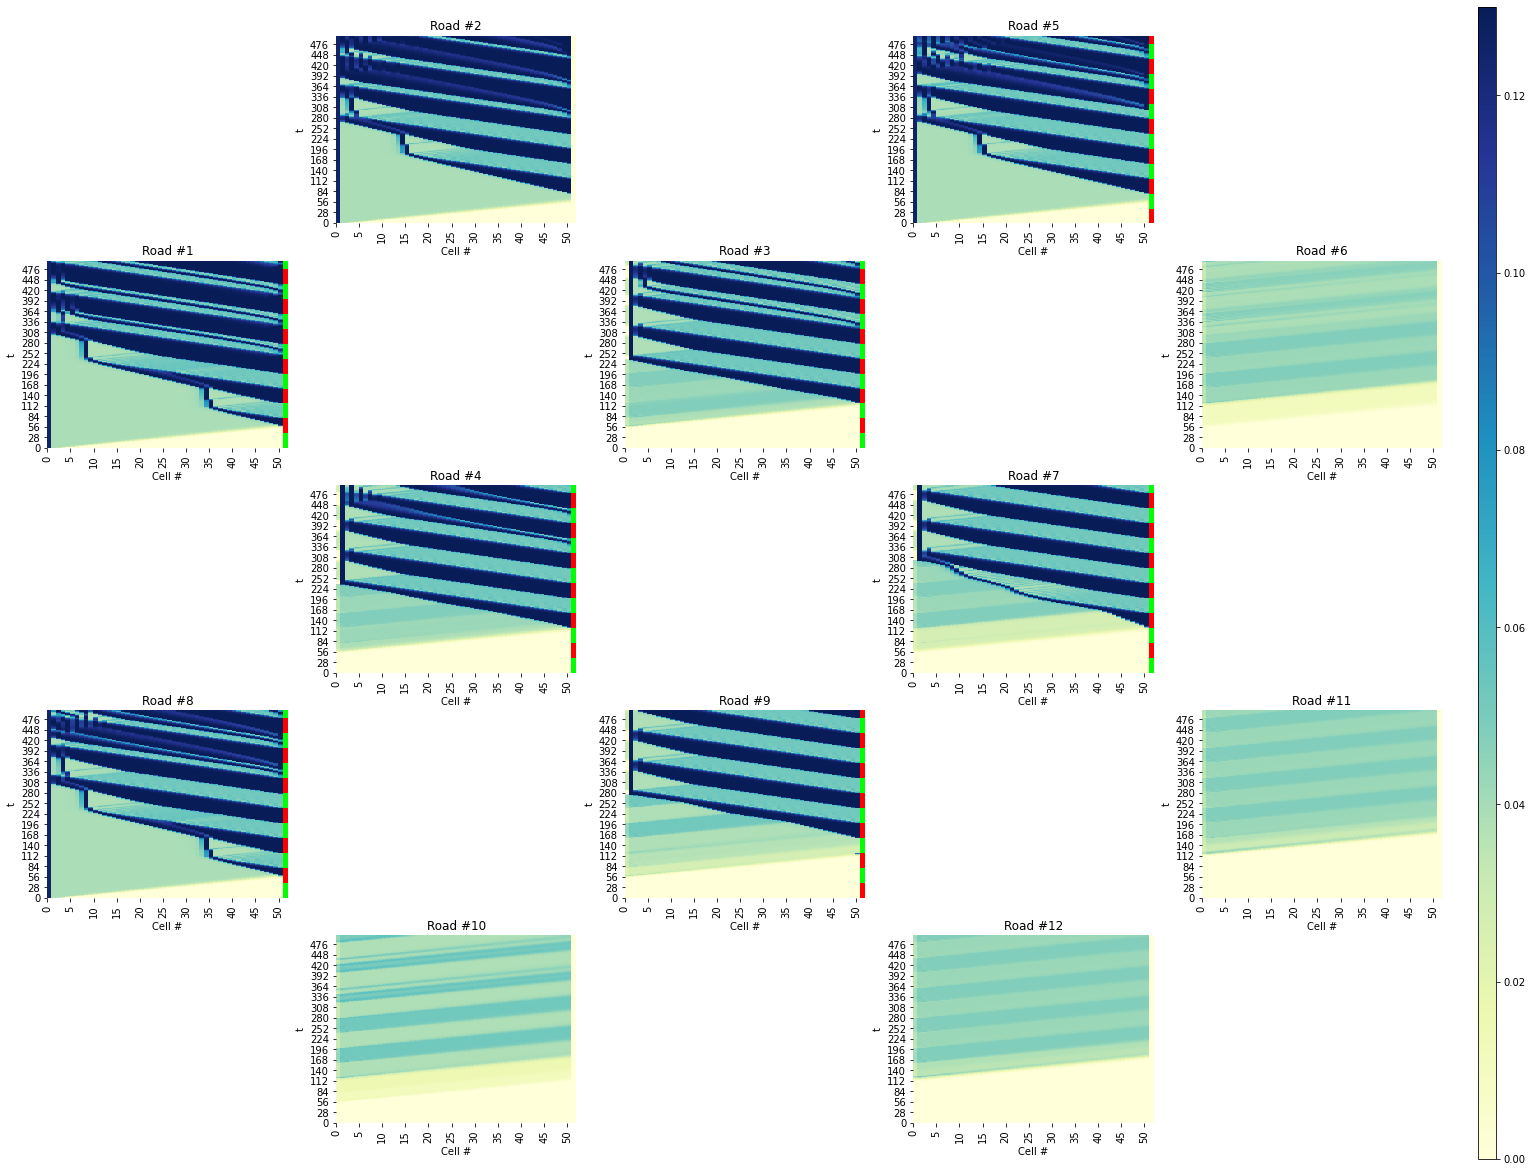

In [59]:
%matplotlib inline
from matplotlib.collections import QuadMesh
from math import floor, ceil
T = 500
delta_t = 3
turnrate = np.array([
                     [0.0, 0.0, 0.7, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                     [0.0, 0.0, 0.3, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0], 
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.7, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.7],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     ])
order = [6, 11, 12, 9, 7, 5, 3, 10, 4, 1, 2, 8]
order = [i-1 for i in order]
stoplight = [(0, 40, 80), (40, 80, 80), (0, 40, 80), (0, 40, 80), (40, 80, 80), 0, (0, 40, 80), (0, 40, 80), (40, 80, 80), 0, 0, 0]
network = Network(turnrate, order, stoplight)
records = network.simulate(T)

num_rows = ceil(len(order) / 2)
num_cols = 2
density_records = [pd.DataFrame(records['density'][i]) for i in range(len(order))]
fig, axes = plt.subplots(5, 5, figsize=(25, 20)) 

mapping = {
    (0, 0) : (1, 0), 
    (0, 1) : (0, 1),
    (1, 0) : (1, 2),
    (1, 1) : (2, 1),
    (2, 0) : (0, 3),
    (2, 1) : (1, 4),
    (3, 0) : (2, 3),
    (3, 1) : (3, 0),
    (4, 0) : (3, 2),
    (4, 1) : (4, 1),
    (5, 0) : (3, 4),
    (5, 1) : (4, 3),
}

color_map = plt.cm.get_cmap('YlGnBu')
# color_map = color_map.reversed()
for r in range(len(order)):
  i = r // 2
  j = r % 2
  i, j = mapping[i, j]
  # sns.heatmap(density_records[r], cmap="YlGnBu", ax = axes[i, j], vmin=0.0, vmax=0.13)
  sns.heatmap(density_records[r], cmap=color_map, ax = axes[i, j], cbar=False, vmin=0.0, vmax=0.13)

for i, ax in enumerate(axes.flat):
  ax.axis('off')

for i in range(num_rows):
  for j in range(num_cols):
    if (i, j) not in mapping:
      continue
    axes[mapping[i,j]].invert_yaxis()
    axes[mapping[i,j]].set_xticks(list(range(0, 52, 5)))
    axes[mapping[i,j]].set_xticklabels(list(range(0, 52, 5)))
    axes[mapping[i,j]].set_ylabel('t')
    axes[mapping[i,j]].set_xlabel('Cell #')
    axes[mapping[i,j]].set_title(f'Road #{2*i + j + 1}')
    axes[mapping[i,j]].axis('on')
    if 2*i + j >= len(order):
      # axes[mapping[i,j]].clear()
      # axes[mapping[i,j]].axis('off')
      continue

    if not stoplight[2*i + j]:
      continue

    id = 2*i + j
    quadmesh = axes[mapping[i,j]].findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()
    green_zone = np.array([True  if stoplight[id][0] <= i%stoplight[id][2] < stoplight[id][1] else False for i in np.arange(T)])
    red_zone = ~green_zone
    make_green = np.arange(51, len(facecolors), 52)[green_zone]
    make_red = np.arange(51, len(facecolors), 52)[red_zone]
    facecolors[make_green] = np.array([0,1,0,1])
    facecolors[make_red] = np.array([1,0,0,1])
    quadmesh.set_facecolors(facecolors)

cbar_ax = fig.add_axes([.92, .1, .01, .8])
fig.colorbar(axes[0, 1].collections[0], cax=cbar_ax)
# fig.tight_layout()
plt.show()

In [7]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
from matplotlib import rc
rc('animation', html='jshtml')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.collections import QuadMesh

n = 10
legend = True

def update(frame):
  global legend
  fig.suptitle(f't = {frame}')
  # fig.clear()
  axes[0,0].clear()
  axes[0,1].clear()
  axes[1,0].clear()
  axes[1,1].clear()

  sns.heatmap(density_records[0].iloc[frame:frame+1, :], cmap="YlGnBu", ax = axes[0,0], cbar=legend, vmin=0.0, vmax=0.13)
  sns.heatmap(density_records[1].iloc[frame:frame+1, :], cmap="YlGnBu", ax = axes[0,1], cbar=legend, vmin=0.0, vmax=0.13)
  sns.heatmap(density_records[2].iloc[frame:frame+1, :], cmap="YlGnBu", ax = axes[1,0], cbar=legend, vmin=0.0, vmax=0.13)
  sns.heatmap(density_records[3].iloc[frame:frame+1, :], cmap="YlGnBu", ax = axes[1,1], cbar=legend, vmin=0.0, vmax=0.13)

  quadmesh = axes[0,0].findobj(QuadMesh)[0]
  facecolors = quadmesh.get_facecolors()
  is_green = 0 <= frame%80 < 40
  if is_green:
    facecolors[51] = np.array([0,1,0,1])
  else:
    facecolors[51] = np.array([1,0,0,1])
  quadmesh.set_facecolors(facecolors)

  quadmesh = axes[0,1].findobj(QuadMesh)[0]
  facecolors = quadmesh.get_facecolors()
  is_green = 40 <= frame%80 < 80
  if is_green:
    facecolors[51] = np.array([0,1,0,1])
  else:
    facecolors[51] = np.array([1,0,0,1])
  quadmesh.set_facecolors(facecolors)
  
  for i in range(2):
    for j in range(2):
      axes[i,j].invert_yaxis()
      axes[i,j].set_xticks(list(range(0, 52, 5)))
      axes[i,j].set_xticklabels(list(range(0, 52, 5)))
      axes[i,j].set_yticks([])
      axes[i,j].set_xlabel('Cell #')
      axes[i,j].set_title(f'Road #{i*2+j+1}')

      if legend:
        cbar = axes[i,j].collections[0].colorbar
        cbar.set_ticks([0.0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12])

      
  fig.tight_layout()
  legend = False


fig, axes = plt.subplots(2, 2, figsize=(15, 5)) 

a = anim.FuncAnimation(fig, update, frames=n, interval=100, blit=True)
a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [8]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
from matplotlib import rc
rc('animation', html='jshtml')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.collections import QuadMesh

n = 10
legend = True

def update(frame):
  global legend
  fig.suptitle(f't = {frame}')
  # fig.clear()
  for i in range(num_rows):
    for j in range(num_cols):
      axes[i, j].clear()

  for r in range(len(order)):
    i = r // 2
    j = r % 2
    sns.heatmap(density_records[r].iloc[frame:frame+1, :], cmap=color_map, ax = axes[i,j], cbar=legend, vmin=0.0, vmax=0.13)
  
  for r in range(len(order)):
    if not stoplight[r]:
      continue

    i = r // 2
    j = r % 2

    quadmesh = axes[i,j].findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()
    is_green = stoplight[r][0] <= frame%stoplight[r][2] < stoplight[r][1]
    if is_green:
      facecolors[51] = np.array([0,1,0,1])
    else:
      facecolors[51] = np.array([1,0,0,1])
    quadmesh.set_facecolors(facecolors)


  
  for i in range(num_rows):
    for j in range(num_cols):
      axes[i,j].invert_yaxis()
      axes[i,j].set_xticks(list(range(0, 52, 5)))
      axes[i,j].set_xticklabels(list(range(0, 52, 5)))
      axes[i,j].set_yticks([])
      axes[i,j].set_xlabel('Cell #')
      axes[i,j].set_title(f'Road #{i*2+j+1}')

      if 2*i + j >= len(order):
        axes[i, j].clear()
        axes[i, j].axis('off')
        continue

      if legend:
        cbar = axes[i,j].collections[0].colorbar
        cbar.set_ticks([0.0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12])


 
  fig.tight_layout()
  legend = False


fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 2.5 * num_rows)) 

a = anim.FuncAnimation(fig, update, frames=n, interval=100, blit=True)
a

<IPython.core.display.Javascript object>

In [9]:
a.save('thesis-thingo.mp4')